In [ ]:
#If you want to obtain the results for the entanglement switched on, please set default for entanglement parameter to 1. 

In [47]:
#Making "from qencode.encoders import e1_classic" work in the jupyter notebook
import sys
import os
sys.path.insert(0, '../')

#importing libraries
import pennylane as qml
import torch
from torchvision import datasets, transforms
import argparse
from scipy.linalg import sqrtm
from pennylane import numpy as np
from tqdm import tqdm
from torch.utils.data import RandomSampler, SubsetRandomSampler

#importing defined functions from the repository
from qencode.encoders import e1_classic

In [48]:
#Defining arguments 
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', default=10)
parser.add_argument('--img_width', default=2)
parser.add_argument('--img_height', default=4)
parser.add_argument('--nr_batches_per_epoch', default=10)
parser.add_argument('--entanglement', default=1) #0 = no entanglement, 1= entanglement assisted

#args = parser.parse_args()       # running not in notebook
args = parser.parse_args(args=[]) # running in notebook 

In [49]:
#Importing MNIST dataset
def get_dataset(img_width, img_height, train):
    trainset = datasets.MNIST(root='./dataset', train=train, download=True,
                              transform=transforms.Compose(
                                  [transforms.Resize((img_width, img_height)), transforms.ToTensor()])
                              )
    return trainset

#Creating train and test datasets
train_loader = torch.utils.data.DataLoader(get_dataset(args.img_width, args.img_height, train=True), \
                                           batch_size=args.batch_size, sampler=RandomSampler(get_dataset(args.img_width, args.img_height, train=True), replacement=True, num_samples=args.nr_batches_per_epoch*args.batch_size))
test_loader = torch.utils.data.DataLoader(get_dataset(args.img_width, args.img_height, train=False), batch_size=1, sampler = SubsetRandomSampler([i for i in range(1000)]))

In [50]:
#defining number of qubits (distinguishing the case with and without entanglement)

wires=[0,1,2,3,4] #data=0,1,2 #ref=3,4

#setting up a quantum device 
dev = qml.device("default.qubit", wires=wires)
shots = 1024

In [51]:
#defining the Quantum Auto Encoder circuit with and without entanglement
@qml.qnode(dev)
def QAE(inputs,encoder_params, decoder_params,mode): 

    
    #Prepare entanglement qubits
    if args.entanglement == 1:
        
        #Creating a Bell state on the 1st pair
        qml.PauliX(wires=0)
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0,3])
        qml.PauliX(wires=1)
        qml.Hadamard(wires=1)
        qml.CNOT(wires=[1,4])

    #Reference qubits require no preparation
    
    #INITIALIZATION:
    #Encode a picture using Amplitude Embedding
    qml.AmplitudeEmbedding(inputs, wires=[0,1,2],normalize=True)
    
    #ENCODER
    e1_classic(encoder_params,[0,1,2]) 

    #DECODER
    
    qml.adjoint(e1_classic)(decoder_params,[3,4,2])
    
    #Going back to |000> state
    qml.adjoint(qml.AmplitudeEmbedding)(inputs, wires=[3,4,2],normalize=True)

        
    if mode=="train":
        return qml.probs([0,1,3,4,2])
    if mode=="evaluate":
        return qml.density_matrix([3,4,2])

In [52]:
#Calculating the number of parameters in the encoder
nr_qubits_encoder = 3 
nr_par_encoder = 2 * 3 * nr_qubits_encoder + 3 * (nr_qubits_encoder - 1) * nr_qubits_encoder

In [53]:
#Defining the loss function
def loss_function(datapoint, params):
    circuit_output =  QAE(datapoint,params[0:nr_par_encoder],params[nr_par_encoder:2*nr_par_encoder],"train")
    loss = (1 - circuit_output[0]) + np.sum(circuit_output[1:])
    return loss

In [54]:
#Initializing parameters
params = np.random.normal(size=(2*nr_par_encoder), requires_grad=True)

In [55]:
#Optimizing the parameters of the encoder 
opt = qml.AdamOptimizer()
epochs = 100

#Cost function - Imposing fidelity=1 for the trash and reference qubits
def cost(params, batch):
    loss = 0.0
    for datapoint in batch:
        loss += loss_function(datapoint, params)
    return loss / batch.shape[0]

In [56]:
#Running the training
for i in range(epochs):
    print(f'Epoch {i}')
    loss = 0
    for batch, y in tqdm(train_loader):
        batch = batch.reshape(-1, args.img_height*args.img_width)
        loss += cost(params,batch)
        params = opt.step(cost, params, batch=batch)
    print(loss / args.nr_batches_per_epoch)
    

Epoch 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.37s/it]


1.8650664650826652
Epoch 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.24s/it]


1.5776428173170485
Epoch 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.14s/it]


1.332694005192419
Epoch 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.16s/it]


1.0806949953365508
Epoch 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


0.8743289602438494
Epoch 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.14s/it]


0.7177042290361884
Epoch 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.13s/it]


0.5400201126825482
Epoch 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.15s/it]


0.41173040885659995
Epoch 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.14s/it]


0.3758354740664317
Epoch 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.13s/it]


0.3266638122046524
Epoch 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.15s/it]


0.2753615246154268
Epoch 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.27s/it]


0.27194960454584166
Epoch 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]


0.2573573283819144
Epoch 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.14s/it]


0.23458885184456454
Epoch 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.15s/it]


0.21620897408076362
Epoch 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.26s/it]


0.22191122797877266
Epoch 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.31s/it]


0.2315941840873835
Epoch 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.30s/it]


0.238290477699001
Epoch 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.35s/it]


0.218056657402569
Epoch 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.32s/it]


0.16038332960097618
Epoch 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.25s/it]


0.18961975637030887
Epoch 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.16s/it]


0.19105211773721756
Epoch 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.21s/it]


0.22858638555013341
Epoch 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


0.2037828444758451
Epoch 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.12s/it]


0.2070267885207257
Epoch 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


0.1688606851835706
Epoch 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.36s/it]


0.21257609495205862
Epoch 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.26s/it]


0.16793235971022033
Epoch 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.16s/it]


0.18191091860792302
Epoch 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.18s/it]


0.19318456315941596
Epoch 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.15s/it]


0.17316256247791806
Epoch 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.25s/it]


0.17953174395560548
Epoch 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.32s/it]


0.18023471374234043
Epoch 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.28s/it]


0.174072260988488
Epoch 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.58s/it]


0.19141171826862716
Epoch 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.42s/it]


0.2047446361793522
Epoch 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.49s/it]


0.16628246071078487
Epoch 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.20s/it]


0.20303090928660056
Epoch 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


0.18083054295411533
Epoch 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


0.19268922469541577
Epoch 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.43s/it]


0.2022390285021675
Epoch 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.05s/it]


0.21328790694205493
Epoch 42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]


0.1860675884103596
Epoch 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.47s/it]


0.17754728646347454
Epoch 44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


0.16263944556937093
Epoch 45


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.52s/it]


0.18741263118542323
Epoch 46


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


0.22412400494098952
Epoch 47


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.18s/it]


0.17821429316060963
Epoch 48


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


0.16286112251864776
Epoch 49


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.17s/it]


0.16686382396885557
Epoch 50


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.36s/it]


0.163867808115445
Epoch 51


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.27s/it]


0.17294752738050925
Epoch 52


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.33s/it]


0.15668587159125344
Epoch 53


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.28s/it]


0.15865110614206143
Epoch 54


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.32s/it]


0.15826686047266494
Epoch 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.49s/it]


0.19354729538902524
Epoch 56


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.36s/it]


0.16799090385620197
Epoch 57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.37s/it]


0.17735790892873865
Epoch 58


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]


0.2010937217181005
Epoch 59


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.19s/it]


0.18209963780018407
Epoch 60


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.51s/it]


0.1682491879388069
Epoch 61


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.40s/it]


0.15673380583207303
Epoch 62


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.66s/it]


0.17325921271162387
Epoch 63


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.36s/it]


0.15675278086197536
Epoch 64


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.37s/it]


0.18644762813331262
Epoch 65


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.55s/it]


0.19385765976422467
Epoch 66


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.75s/it]


0.19816707966416552
Epoch 67


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.18s/it]


0.16662288968385414
Epoch 68


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.18s/it]


0.17288350786597256
Epoch 69


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.15s/it]


0.15746891424247045
Epoch 70


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.15s/it]


0.16242368551573844
Epoch 71


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.12s/it]


0.1544768338164125
Epoch 72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.17s/it]


0.1990294207612217
Epoch 73


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.17s/it]


0.21265498791796839
Epoch 74


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


0.17224634581969472
Epoch 75


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.17s/it]


0.20539368242119432
Epoch 76


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.48s/it]


0.18482014288426302
Epoch 77


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.79s/it]


0.16723242403705724
Epoch 78


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.49s/it]


0.1872679098065066
Epoch 79


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.97s/it]


0.1679552337771955
Epoch 80


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.35s/it]


0.19430594257332692
Epoch 81


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.28s/it]


0.1921362026263615
Epoch 82


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.07s/it]


0.1805581922057912
Epoch 83


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.85s/it]


0.18267494321003247
Epoch 84


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


0.1859222582443695
Epoch 85


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


0.1983125106464204
Epoch 86


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]


0.171896475936357
Epoch 87


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]


0.1698742951317091
Epoch 88


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


0.17795502301325178
Epoch 89


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.16s/it]


0.16225015601590226
Epoch 90


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.42s/it]


0.19687961172100688
Epoch 91


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.56s/it]


0.17962465286208068
Epoch 92


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.39s/it]


0.18189297604848478
Epoch 93


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.08s/it]


0.16748337183981135
Epoch 94


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.34s/it]


0.17720875209220016
Epoch 95


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.09s/it]


0.1585280001390492
Epoch 96


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/it]


0.1571974316028739
Epoch 97


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.31s/it]


0.20512979045443247
Epoch 98


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.35s/it]


0.1896772497059021
Epoch 99


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.33s/it]

0.18057789168353813


In [57]:
#Evaluating the faithfulness of the Quantum Auto Encoder

def fidelity(rho, sigma):
    # Inputs rho and sigma are density matrices
    sqrt_sigma = sqrtm(sigma)
    fid = np.trace(sqrtm(sqrt_sigma @ rho @ sqrt_sigma))
    return fid.real

def evaluate_similarity(datapoint, params):
    state_before=np.zeros((2**3,2**3))
    state_before[0,0]=1
    state_after=QAE(datapoint,params[0:nr_par_encoder],params[nr_par_encoder:2*nr_par_encoder], "evaluate")
    return fidelity(state_before, state_after)

In [58]:
results = []
for batch, y in tqdm(test_loader):
    batch = batch.reshape(-1, args.img_height*args.img_width)
    results.append(evaluate_similarity(batch[0], params))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 20.96it/s]


In [58]:
results_ent = []
for batch, y in tqdm(test_loader):
    batch = batch.reshape(-1, args.img_height*args.img_width)
    results_ent.append(evaluate_similarity(batch[0], params))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 20.96it/s]


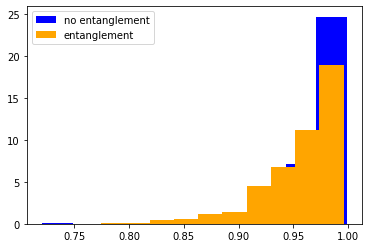

In [59]:
import matplotlib.pyplot as plt
plt.hist(results, density=True, color="blue", label="no entanglement")
plt.hist(results_ent, density=True, color="orange", label="entanglement")
plt.legend()
plt.show()

In [60]:
np.mean(results)

0.9729240928397169

In [61]:
np.mean(results_ent)

0.9569929368408723